In [223]:
#commented unecessary print statements
#defined functions in order to use numba pre compiler
#coverted some unecessary matrices to scalras inorder to conserve memory (eg. random numbers)

#contains the Watts-Strogatz initial network as a separate function

#random nodes are infected initially. This may not highlight the properties of the network. 
#That is, it might not differentiate between small world networks and large world networks. 

In [224]:
#importing the required libraries

import networkx as nx #network library to generate inital networks and perform various network operations
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
import cProfile #for timing the loops
from numba import jit #numba precomplier to make the code faster
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy

In [225]:
#opening a file to store data
f = open("blah","w+") 

In [226]:
#making the nodes interact

# @jit(nopython=True)
def interaction(N,k,adj_mat,indi_state,p,counter) :
    suscep_node_list = susceptible_node_list(G,k,indi_state)
    
    for e in G.edges() : #loop to go through all the edges of the current graph which changes at each time step
        H = G
        n = e[0]
        partner = e[1]
        z11 = np.random.uniform() #choosing either rewiring or interaction
        z12 = np.random.uniform() #if interaction, then susceptible becoming infected 
        z13 = np.random.uniform() #if interaction, then infected becoming susceptible 
        
        #if one is infected and the other is susceptible and they are connected \
        #or if the other is infected and the one is susceptible and they are connected
        
        #SI link
        if ((indi_state[n,k-1] == 1) and (indi_state[partner,k-1] == 2)) or ((indi_state[n,k-1] == 2) and (indi_state[partner,k-1] == 1)):
            if w >= z11 and (len(suscep_node_list)!=0) : #rewiring
                if (len(suscep_node_list) == 1) and (suscep_node_list[0] == n) : #if there is only one susceptible node and it is not the same node (to prevent rewiring to itself)
                    int_keeping_si(indi_state,partner,n,k,z12,z13,p,r)
                else :
                    H = deepcopy(new_link(G,indi_state,n,k,suscep_node_list,partner))
                    counter = counter + 1
            else : #no change in network. Continue keeping the same G
                int_keeping_si(indi_state,partner,n,k,z12,z13,p,r)
        #II link               
        #if both are infected and they are connected
        elif ((indi_state[n,k-1] == 2) and (indi_state[partner,k-1] == 2)) :
            ii_link_interaction(r,z13,indi_state,partner,n,k)
        
        #neither SI nor II
        else :
#             'no interaction at all'
          indi_state[n,k] = indi_state[n,k-1]
          indi_state[partner,k] = indi_state[partner,k-1]

    return indi_state,counter, H

In [227]:
#creating a list of nodes of the current graph which are susceptible after the previous time step

def susceptible_node_list(G,k,indi_state) :
    G_temp = deepcopy(G)
    suscep_node_list = []
    for i in G_temp.nodes() :
        if indi_state[i,k-1] == 1 :
            suscep_node_list.extend([i])
#         else :
#             print('no more susceptible nodes exist to link to')
    
    return suscep_node_list

In [228]:
def new_link(G,indi_state,n,k,suscep_node_list,partner) :
    G_temp = deepcopy(G)
#breaking SI and making a new link with some other random S and also giving a chance for the I to recover
    if indi_state[n,k-1] == 1 : #identifying which one of the two is susceptible
        G_temp.remove_edge(n,partner)
        #identify some other random susceptible node
        rand_suscep_node = random.choice(suscep_node_list)
        while (rand_suscep_node == n) : #making sure that the susceptible node does not re-link to itself
            rand_suscep_node = random.choice(suscep_node_list)
        G_temp.add_edge(n,rand_suscep_node)

    else :
        G_temp.remove_edge(n,partner)
        #identify some other random susceptible node
        rand_suscep_node = random.choice(suscep_node_list)
        while (rand_suscep_node == partner) : #making sure that the susceptible node does not re-link to itself
            rand_suscep_node = random.choice(suscep_node_list)
        G_temp.add_edge(partner,rand_suscep_node)
        
    return G_temp

In [229]:
def int_keeping_si(indi_state,partner,n,k,z12,z13,p,r) :
#interaction keeping SI
    if p >= z12 :
        #susceptible becomes infected and the other infected can become susceptible
        if indi_state[n,k-1] == 1 : #identifying which one of the two is susceptible
            indi_state[n,k] = 2 #susceptible becomes infected
            if r >= z13 : 
                indi_state[partner,k] = 1 #infected becomes susceptible
            else :
                 indi_state[partner,k] == indi_state[partner,k-1] #infected remains infected
        else :
            indi_state[partner,k] = 2 #susceptible becomes infected
            if r >= z13 : 
                indi_state[n,k] = 1 #infected becomes susceptible
            else :
                indi_state[n,k] = indi_state[n,k-1] #infected remains infected
    else :
        #susceptible remains susceptible but the other infected can become susceptible
        if r >= z13 :
            if indi_state[n,k-1] == 2 : #identifying which of the two is infected
                indi_state[n,k] = 1
                indi_state[partner,k] = indi_state[partner,k-1]
            else :
                indi_state[n,k] = indi_state[n,k-1]
                indi_state[partner,k] = 1
        else :
                indi_state[n,k] = indi_state[n,k-1]
                indi_state[partner,k] = indi_state[partner,k-1]
         
    return indi_state

In [230]:
def ii_link_interaction(r,z13,indi_state,partner,n,k) : 
    if r >= z13 : 
        indi_state[n,k] = 1
        indi_state[partner,k] = 1
    else :
        indi_state[n,k] = indi_state[n,k-1]
        indi_state[partner,k] = indi_state[partner,k-1]
        
    return indi_state

In [231]:
#creating the static Watts-Strogatz network
def static_network(N,nn,p_rew) :
    G = nx.watts_strogatz_graph(N,nn,p_rew) 
#     print("G_type = ",type(G))

    # #relabelling the nodes to start with 1
    # G = nx.convert_node_labels_to_integers(G,first_label=1,ordering='default',label_attribute=None)

    #getting the nodes as a list
    node_list = [G.nodes]

    #and converting it into an array(column vector)
    node_array = np.asarray(node_list).reshape(N,1)


    #obtaining the edges via the adjancency matrix
    adj_mat = nx.adjacency_matrix(G,nodelist=range(N))
    adj_mat = scipy.sparse.csr_matrix.toarray(adj_mat)
    
#     connec_neigh_list = list(G.neighbors(n))
    
    return G, adj_mat
#     print("adj_mat_type = ",type(adj_mat))
#     print("adj_mat_shape = ",adj_mat.shape)
#     print(adj_mat)

#     nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')
    

In [232]:
#user controlled variables

for p in range(0,11) : #time loop
    p = p*0.1
#     p = 1
    print("p=",p)
    for start in range(0,11) : #initial condition loop
        start = start*0.1
#         start = 1
        print("start=",start)
        for r in range(0,11) : #infected recovering to susceptible
            r = r*0.1
            print("r=",r)
#             p_rew = 1
#             print("p_rew=",p_rew)
            
            w = 0.5 #probability of SI link rewiring to SS
            
            p_rew = 0.5
            nn = 6 #each node is connected to nn number of nearest neighbours, nn-1 neighbors if nn is odd


            N = 100   #number of individuals
            T = 1000  #number of time steps

            phi = 999*np.ones([1,T]) #fraction of steady state infected

            t = np.arange(0,T) #time steps
            t = np.asarray(t).reshape(1,T)

#             partner = 999*np.ones((N,T),dtype=np.int32) #partners used to form pairs in every time step
#             partner = np.asarray(partner)

            indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
            indi_state[:,0] = 1


            #initial state of individuals

            infec = random.sample(range(0, N), np.int32(start*N)) #radnomly infecting few individuals as initial condition
            # np.random.shuffle(infec)
            infec = np.asarray(infec).reshape(np.int32(start*N),1)
            if start != 0 :
                indi_state[infec[:,0],0] = 2

            phi[0,0] = np.count_nonzero(indi_state[:,0] == 2)/N

            
            #creating the static network
            G, adj_mat = static_network(N,nn,p_rew) #calling the function to create the static network
#             print(adj_mat)
#             nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')

            for k in range(1,T): #loop for time
#                 print('k = ',k)
                counter = 0 #to check whether rewiring has taken place
                indi_state, counter, H = interaction(N,k,adj_mat,indi_state,p,counter) #calling the interaction function
                phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
                
#                 f.write("%f\t%f\n" % (k,phi[0,k]))
#                 f.flush()
                if counter != 0 : #rewiring has taken place
                    G = deepcopy(H) #replacing the exisitng graph with a new graph
                
            phi_star = sum(phi[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
            print("phi_star=",phi_star)

            f.write("%f\t%f\t%f\t%f\n" % (p,start,r,phi_star))
            f.flush()

p= 0.0
start= 0.0
r= 0.0
phi_star= 0.0
r= 0.1
phi_star= 0.0
r= 0.2
phi_star= 0.0
r= 0.30000000000000004
phi_star= 0.0
r= 0.4
phi_star= 0.0
r= 0.5
phi_star= 0.0
r= 0.6000000000000001
phi_star= 0.0
r= 0.7000000000000001
phi_star= 0.0
r= 0.8
phi_star= 0.0
r= 0.9
phi_star= 0.0
r= 1.0
phi_star= 0.0
start= 0.1
r= 0.0
phi_star= 0.02999999999999995
r= 0.1
phi_star= 0.0
r= 0.2
phi_star= 0.0
r= 0.30000000000000004
phi_star= 0.0
r= 0.4
phi_star= 0.0
r= 0.5
phi_star= 0.0
r= 0.6000000000000001
phi_star= 0.0
r= 0.7000000000000001
phi_star= 0.0
r= 0.8
phi_star= 0.0
r= 0.9
phi_star= 0.0
r= 1.0
phi_star= 0.0
start= 0.2
r= 0.0
phi_star= 0.14000000000000018
r= 0.1
phi_star= 0.0
r= 0.2
phi_star= 0.0
r= 0.30000000000000004
phi_star= 0.0
r= 0.4
phi_star= 0.0
r= 0.5
phi_star= 0.0
r= 0.6000000000000001
phi_star= 0.0
r= 0.7000000000000001
phi_star= 0.0
r= 0.8
phi_star= 0.0
r= 0.9
phi_star= 0.0
r= 1.0
phi_star= 0.0
start= 0.30000000000000004
r= 0.0
phi_star= 0.2600000000000005
r= 0.1
phi_star= 0.0
r= 0.2
phi_st

KeyboardInterrupt: 

In [ ]:
%timeit interaction(N,k,adj_mat,indi_state,p,counter)
# %timeit new_link(G,indi_state,n,k)
# %timeit int_keeping_si(indi_state,partner,n,k,z12,z13)
# %timeit ii_link_interaction(r,z13,indi_state,partner,n,k)

In [ ]:
# a = np.loadtxt("local_epid_p_phiini_prewphi_star_data.txt")[:,0]
# b =  np.loadtxt("local_epid_p_phiini_prewphi_star_data.txt")[:,1]
# c =  np.loadtxt("local_epid_p_phiini_prewphi_star_data.txt")[:,2]
# d = np.loadtxt("local_epid_p_phiini_prewphi_star_data.txt")[:,3]

# # Import dependencies
# import plotly
# import plotly.graph_objs as go

# # Configure Plotly to be rendered inline in the notebook.
# plotly.offline.init_notebook_mode()

# # Configure the trace.
# trace = go.Scatter3d(
#     x= a.transpose(),  # <-- Put your data instead
#     y= b.transpose(),  # <-- Put your data instead
#     z= c.transpose(),  # <-- Put your data instead
#     mode='markers',
#     marker=dict(
#         size=12,
#         color=d,                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         colorbar = dict(title = ''),
#         opacity=0.8
#     )
# )

# # Configure the layout.
# layout = go.Layout(
#                     scene = dict(
#                     xaxis = dict(
#                         title='p'),
#                     yaxis = dict(
#                         title=r'$phi_{ini}$'),
#                     zaxis = dict(
#                         title= r'$p_{rew}$'),),
#                     width=700,
#                     margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
#                     )

# data = [trace]

# plot_figure = go.Figure(data=data, layout=layout)

# # Render the plot.
# plotly.offline.iplot(plot_figure)

AxesSubplot(0.125,0.536818;0.352273x0.343182)
AxesSubplot(0.547727,0.536818;0.352273x0.343182)
AxesSubplot(0.125,0.125;0.352273x0.343182)
AxesSubplot(0.547727,0.125;0.352273x0.343182)


NameError: name 'im' is not defined

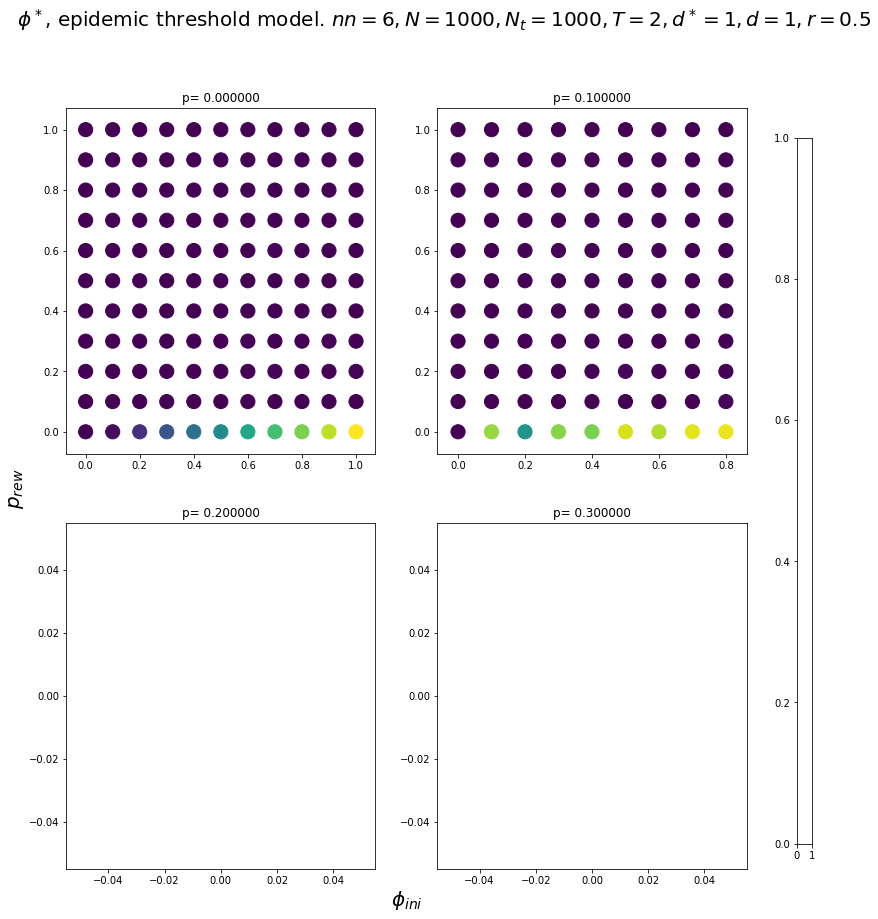

In [238]:
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("blah.txt")[:,3]


counter = 0
l = 0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(col)
        ax[i, k].set_title('p= %f' %l)
        l = l + 0.1
        j = 121*counter
        col.scatter(np.loadtxt("blah.txt")[j:121*(counter+1),1],np.loadtxt("blah.txt")[j:121*(counter+1),2], c=np.loadtxt("blah.txt")[j:121*(counter+1),3],s=200,vmin=0, vmax=1)
        k = k + 1
        counter = counter + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$\phi^*$, epidemic threshold model. $nn=6,N=1000,N_t=1000,T=2,d^*=1,d=1,r=0.5$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("test.svg", format="svg")

# for i in range(1, 13):
#     plt.subplot(4, 3, i)
#     j = 121*counter
#     print(j)
#     plt.scatter(np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),3],s=200)
# #     plt.colorbar()
#     # plt.title(r'$\phi^*$, Critical Threshold Model. $d^*=3,T=12, N=100,N_t=1000,r=1,rho=1$',fontsize=15,fontweight='bold')
#     # plt.title(r'$\phi^*$, Epidemic Threshold Model. $d^*=1,T=2, N=100,N_t=1000,r=0.5,rho=1$',fontsize=15,fontweight='bold')
#     plt.title('p')
#     plt.xlabel(r'$\phi_{ini}$',fontsize=15)
#     plt.ylabel(r'$\phi_{rew}$',fontsize=15)
#     counter = counter + 1 
